# エントリ・タイミングの検討 PSAR & OBV

In [1]:
import datetime

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd

from func.plots import getMajorXTicks2
from func.preprocs import prepOHLC, prepTick
from func.tide import get_range_xaxis

## データ準備

In [68]:
interval = '1m'
code = '8306'
dateStr = '20250129'

### OHLC データの読み込み

In [69]:
ohlcname = 'ohlc/ohlc_%s_%s_%s.csv' % (interval, code, dateStr)
df = pd.read_csv(ohlcname)
df_ohlc = prepOHLC(df)
df_ohlc

,Open,High,Low,Close,Volume,H_Open,H_High,H_Low,H_Close,TREND,EP,AF,PSAR,Period,Diff
Datetime,,,,,,,,,,,,,,,
2025-01-29 09:00:00,1975.0,1975.0,1964.0,1966.5,5899600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-29 09:01:00,1967.0,1973.0,1964.5,1966.5,871000.0,1970.13,1973.0,1964.5,1967.75,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-29 09:02:00,1966.0,1971.5,1965.0,1969.0,622800.0,1968.94,1971.5,1965.0,1967.88,1.0,1971.5,0.02,1971.50,0.0,NaN
2025-01-29 09:03:00,1968.5,1974.0,1968.0,1970.5,667700.0,1968.41,1974.0,1968.0,1970.25,-1.0,1974.0,0.02,1971.50,0.0,NaN
2025-01-29 09:04:00,1970.0,1971.5,1968.0,1968.5,314300.0,1969.33,1971.5,1968.0,1969.50,-1.0,1968.0,0.04,1971.36,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-29 15:26:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-29 15:27:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-29 15:28:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### ティックデータの読み込み

In [70]:
tickname = 'tick/tick_%s_%s.csv' % (code, dateStr)
df = pd.read_csv(tickname)
df_tick = prepTick(df, dateStr)
df_tick

,Price
Datetime,
2025-01-29 09:00:00,1974.5
2025-01-29 09:00:01,1974.0
2025-01-29 09:00:04,1971.5
2025-01-29 09:00:06,1974.0
2025-01-29 09:00:08,1971.5
...,...
2025-01-29 15:24:53,1971.0
2025-01-29 15:24:54,1971.5
2025-01-29 15:24:56,1971.0


# プロット

Matplotlib では、時刻データは matplotlib.dates に従う。

https://matplotlib.org/stable/api/dates_api.html

In [71]:
# 出来高の棒グラフの幅（１分）を算出
dt1 = pd.to_datetime('%s 9:00:00' % dateStr)
mdt1 = mdates.date2num(dt1)
dt2 = pd.to_datetime('%s 15:30:00' % dateStr)
mdt2 = mdates.date2num(dt2)
td = (mdt2 - mdt1) / (6 * 60 + 30)
print(td)

0.0006944444444413351


## OBV の算出

In [72]:
df_ohlc['OBV'] = np.nan

dt_1h1 = pd.to_datetime('%s 9:01:00' % dateStr)
dt_1h2 = pd.to_datetime('%s 11:30:00' % dateStr)
dt_2h1 = pd.to_datetime('%s 12:30:00' % dateStr)
dt_2h2 = pd.to_datetime('%s 15:24:00' % dateStr)

obv_started = False
for t, c, v in zip(df_ohlc.index, df_ohlc['Close'], df_ohlc['Volume']):
    if (dt_1h1 <= t <= dt_1h2) or (dt_2h1 <= t <= dt_2h2):
        if obv_started:
            if c_prev < c:
                obv += v / scale
            elif c < c_prev:
                obv -= v / scale
        else:
            scale = v
            obv = v / scale
            obv_started = True

        df_ohlc.at[t, 'OBV'] = obv
        c_prev = c

    if t == dt_1h2:
        obv_started = False

df_ohlc

,Open,High,Low,Close,Volume,H_Open,H_High,H_Low,H_Close,TREND,EP,AF,PSAR,Period,Diff,OBV
Datetime,,,,,,,,,,,,,,,,
2025-01-29 09:00:00,1975.0,1975.0,1964.0,1966.5,5899600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-29 09:01:00,1967.0,1973.0,1964.5,1966.5,871000.0,1970.13,1973.0,1964.5,1967.75,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
2025-01-29 09:02:00,1966.0,1971.5,1965.0,1969.0,622800.0,1968.94,1971.5,1965.0,1967.88,1.0,1971.5,0.02,1971.50,0.0,NaN,1.715040
2025-01-29 09:03:00,1968.5,1974.0,1968.0,1970.5,667700.0,1968.41,1974.0,1968.0,1970.25,-1.0,1974.0,0.02,1971.50,0.0,NaN,2.481630
2025-01-29 09:04:00,1970.0,1971.5,1968.0,1968.5,314300.0,1969.33,1971.5,1968.0,1969.50,-1.0,1968.0,0.04,1971.36,1.0,2.0,2.120781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-29 15:26:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-29 15:27:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-29 15:28:00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


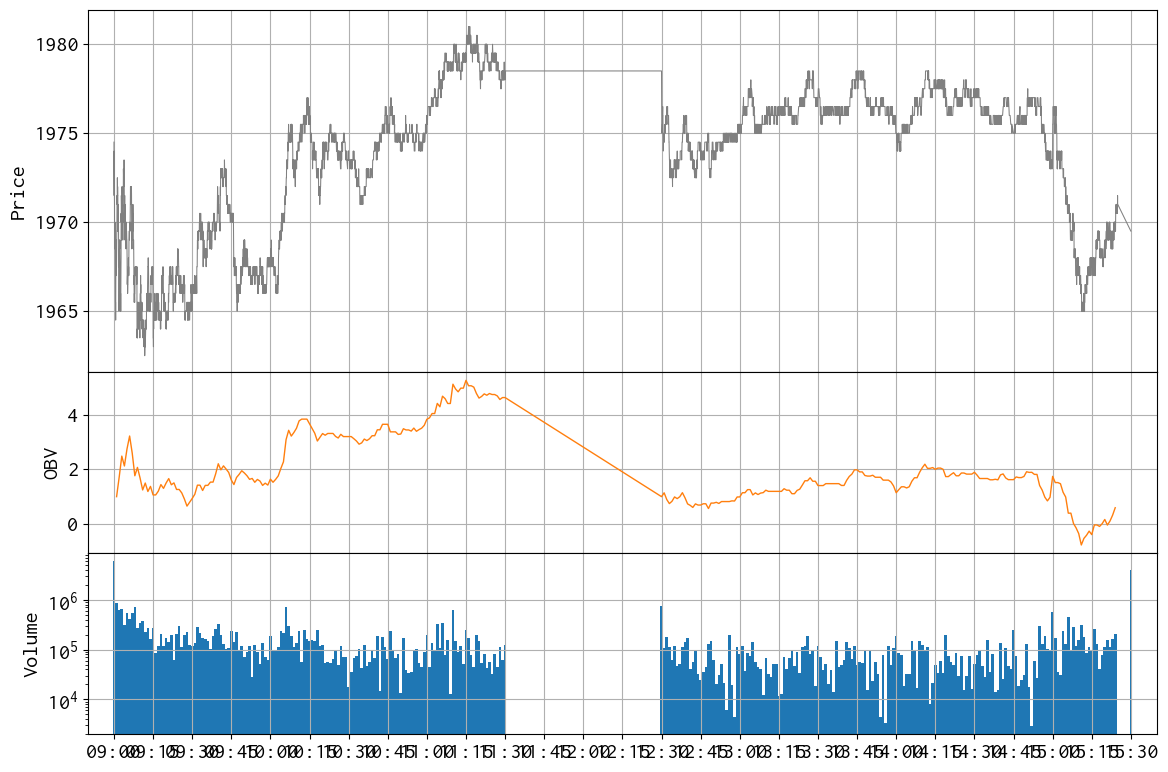

In [73]:
FONT_PATH = 'fonts/RictyDiminished-Regular.ttf'
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 3
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

ax[0].plot(
    df_tick,
    linewidth=0.75,
    color='gray',
)

# X軸の時刻刻みを調整
tick_position, tick_labels = getMajorXTicks2(df_tick)
ax[0].set_xticks(
    ticks=tick_position,
    labels=tick_labels,
)
ax[0].xaxis.set_major_formatter(
    mdates.DateFormatter('%H:%M')
)
"""
ax[0].xaxis.set_minor_locator(
    mdates.MinuteLocator(interval=5)
)
"""
ax[0].set_xlim(
    get_range_xaxis(df_tick)
)

ax[0].set_ylabel('Price')

ax[1].plot(
    df_ohlc['OBV'],
    linewidth=1,
    color='C1',
)
ax[1].set_ylabel('OBV')

ax[2].bar(
    df_ohlc.index, df_ohlc['Volume'],
    width=td,
    align='center',
    color='C0',
)
ax[2].set_yscale('log')
ax[2].set_ylabel('Volume')

plt.tight_layout()
plt.savefig('study_007.png')
plt.show()